In [109]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report


Matplotlib is building the font cache; this may take a moment.


In [2]:
# Create the database connection
con = duckdb.connect(".config/nfl.duckdb")

In [ ]:
# Examine the tables and select one for EDA
con.sql("""
    SELECT *
    FROM bronze.tracking_week_1
    WHERE event != 'NA'
    LIMIT 25
""")

In [ ]:
# NFL Teams ordered by their wins, descending
con.sql("""
    WITH game_results AS (
    SELECT
        homeTeamAbbr AS team,
        CASE
            WHEN homeFinalScore > visitorFinalScore THEN 1
            ELSE 0
        END AS win,
        CASE
            WHEN homeFinalScore < visitorFinalScore THEN 1
            ELSE 0
        END AS loss
    FROM bronze.games
    UNION ALL
    SELECT
        visitorTeamAbbr AS team,
        CASE
            WHEN visitorFinalScore > homeFinalScore THEN 1
            ELSE 0
        END AS win,
        CASE
            WHEN visitorFinalScore < homeFinalScore THEN 1
            ELSE 0
        END AS loss
    FROM bronze.games
    )
    SELECT
        team,
        SUM(win) AS total_wins,
        SUM(loss) AS total_losses
    FROM game_results
    GROUP BY team
    ORDER BY total_wins DESC;

""")

In [79]:
# Creating dataframes with DuckDB
train = con.sql("""
    SELECT *
    FROM bronze.tracking_week_1
    WHERE event != 'NA'
        AND o != 'NA'
        AND dir != 'NA'
        """).df()


In [ ]:
# Generating dummy variables with Pandas
train_one_hot = pd.get_dummies(train[["event"]], drop_first = True)
train_one_hot = pd.concat([train, train_one_hot], axis=1)
train_one_hot = train_one_hot.drop(["event"], axis = 1)
train_one_hot = train_one_hot.drop(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'playDirection', 'club'], axis = 1)
train_one_hot.head()

In [93]:
# Experiment with different types of encoding
train_freq_enc = train
train_frequency = train["event"].value_counts(normalize = True)
train_freq_enc['encoded'] = train_freq_enc['event'].map(train_frequency)
train_freq_enc = train_freq_enc.drop(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'playDirection', 'club'], axis = 1)
train_freq_enc.head() 

,x,y,s,a,dis,o,dir,event,encoded
0,51.06,28.55,0.72,0.37,0.07,246.17,68.34,huddle_break_offense,0.111385
1,51.88,29.07,0.34,0.26,0.03,261.81,303.38,line_set,0.142965
2,50.70,29.39,0.68,0.36,0.07,262.63,297.92,man_in_motion,0.051123
3,50.29,29.43,1.13,1.62,0.11,240.06,133.16,ball_snap,0.144758
4,53.10,26.61,4.66,2.37,0.46,204.08,147.79,handoff,0.049572


In [94]:
# Split the data into features and target
X = train_freq_enc[['x','y', 's', 'a', 'dis', 'o', 'dir']].values
y = train_freq_enc[['encoded']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify=y)

In [100]:
# Instantiate the KFolds and LinearRegression
kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
linreg = LinearRegression()

In [112]:
# Fit the model and print the score
linreg.fit(X, y)
predictions = linreg.predict(X)

In [115]:
y.shape

(296073, 1)

ValueError: x and y must be the same size

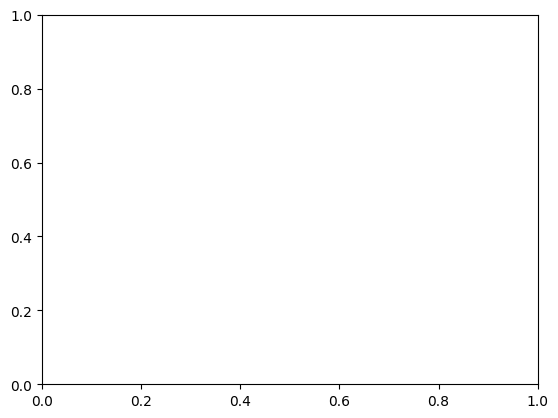

In [ ]:
# Need to use the predictions to attach the event labels to the dataset to plot
# Create scatter plot
plt.scatter(X_train, y_train, color="blue")

# Create line plot
plt.plot(X_train, predictions, color="red")
plt.xlabel("Play data ($)")
plt.ylabel("Event")

# Display the plot
plt.show()